# Resolved Mass-Metallicity Relation with MaNGA

We're going to construct a spatially-resolved mass-metallicity relation for a MaNGA galaxy.

## Key Terms

**DAP**: MaNGA Data Analysis Pipeline, which fits the MaNGA data cubes with stellar continuum and emission line models to produce model data cubes and maps of measured quantities.  
**data cube**: 3D data structure with 1D spectra arranged in a 2D spatial grid  
**IFU**: integral field unit  
**spaxels**: spatial pixels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Maps for Galaxy

In [2]:
from marvin.tools.maps import Maps

INFO: No release version set. Setting default to MPL-6


In [3]:
# filename = ''
# maps = Maps(filename=filename)
maps = Maps('8485-1901')

## Select Only Star-forming Spaxels

Metallicity indicators only work for star-forming spaxels, so we need a way to select only these spaxels.

## BPT Diagram

The classic diagnostic diagram for classify the emission from galaxies (or galactic sub-regions) as star-forming or non-star-forming (i.e., from active galactic nuclei (AGN) or evolved stars) was originally proposed in Baldwin, Phillips, & Terlevich (1981) and is known as the BPT diagram.

The BPT diagram uses ratios of emission lines separate thermal and non-thermal emission.

The classic BPT diagram uses [OIII]5007 / Hbeta vs. [NII]6583 / Halpha, but there are several versions of the BPT diagram that use different lines ratios.

![Dashed line: Kauffmann et al. (2003). Dotted line: Kewley et al. (2001).](files/images/bpt_kauffmann2003.png "BPT")


Let's use Marvin's `get_bpt()` method to make BPT diagrams for this galaxy.

red line: maximal starbust (Kewley et al 2001) -- everything to the right is non-star-forming.

dashed black line: conservative star-forming cut (Kauffmann et al. 2003) -- everything to the left is star-forming.

Line ratios that fall in between these two lines are designated "Composite" with contributions from both star-forming and non-star-forming emission.

blue line: separates AGN into Seyferts and LINERs.

Seyferts are ...

LINERs (Low Ionization Nuclear Emission Regions) are not always nuclear (LIER is a better acronym) and not always AGN (oftern hot evolved stars).

Sometimes these diagnostic diagrams disagree with each other, hence the "Ambiguous" designation.

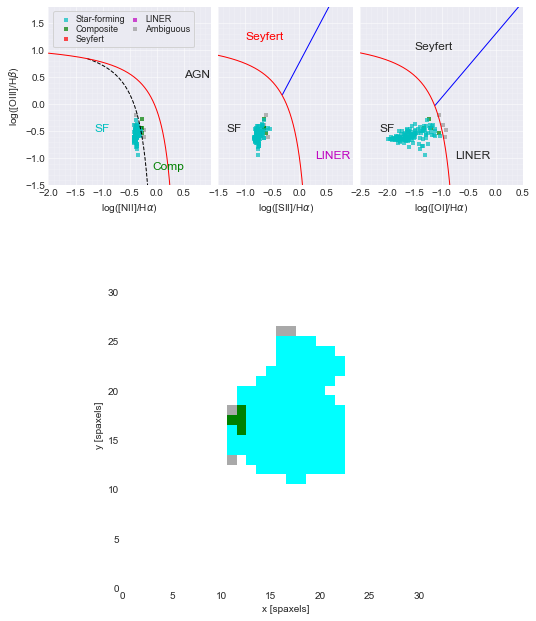

In [4]:
masks, __, __ = maps.get_bpt()

In [6]:
# select spaxels that are classified as star-forming in all three BPT diagrams
masks['sf']['global']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [7]:
# get [NII] 6585 and Halpha maps
# note: MaNGA (and Marvin) use the wavelengths of lines in vaccuum,
# whereas they are usually reported in air, hence the slight offsets
nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564

In [ ]:
# inverse variance = 1 / sigma**2, where sigma is the error.
ha.ivar

In [ ]:
# mask
ha.mask

In [ ]:
# describes mask
ha.pixmask.schema

In [25]:
# Marvin can do map arithmetic.
# It propagates the masks and inverse variances.
n2 = nii / ha

# This does not propagate the inverse variance properly (yet).
logn2 = np.log10(n2)

Pettini & Pagel (2004) N2 metallicity diagnostic

12 + log (O/H) = 8.90 + 0.57 × N2

In [26]:
oh = 8.90 + 0.57 * logn2

In [35]:
# select non-star-forming spaxels and set their mask value to the DAP's DONOTUSE value
mask_non_sf = ~masks['sf']['global'] * ha.pixmask.labels_to_value('DONOTUSE')

mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])

# mask spaxels with low signal-to-noise ratios (SNRs)
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

# Do a bitwise OR between DAP mask and non-star-forming mask.
mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

In [37]:
mask_orig

array([[1073741827, 1073741827, 1073741827, ..., 1073741827, 1073741827,
        1073741827],
       [1073741827, 1073741827, 1073741827, ..., 1073741827, 1073741827,
        1073741827],
       [1073741827, 1073741827, 1073741827, ..., 1073741827, 1073741827,
        1073741827],
       ...,
       [1073741827, 1073741827, 1073741827, ..., 1073741827, 1073741827,
        1073741827],
       [1073741827, 1073741827, 1073741827, ..., 1073741827, 1073741827,
        1073741827],
       [1073741827, 1073741827, 1073741827, ..., 1073741827, 1073741827,
        1073741827]])

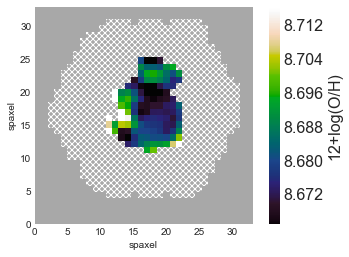

In [24]:
fig, ax = oh.plot(mask=mask, cblabel='12+log(O/H)')

### Jorge's resolved MZR
